In [2]:
import os
from subprocess import run
res = run(["git", "rev-parse", "--show-toplevel"], capture_output=True)
root_dir = res.stdout.decode().strip()
os.chdir(root_dir)

In [6]:
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.interpolate
import astropy.units as u
import astropy

import simdata

%reload_ext autoreload
%autoreload 2
from pprint import pprint
from src.vortector.vortector import Vortector
from src.vortector.visualize import show_fit_overview_2D
from simdata_vorticity import provide_simulation_data

In [7]:
# very hard example overlapping with spiral arm

# simid = "4ae2169c"
# Noutput = 30

# hard example

# simid = "306d9f0c"
# Noutput = 52

# overlapping with boundary example

# simid = "9f976424"
# Noutput = 90

# spiral arm artifact

# simid = "487fa644"
# Noutput = 223

# big vortex example
simid = "3625e016"
Noutput = 200

# easy example

# simid = "a122b63c"
# Noutput = 75

# # faint vortex
# simid = "65a701a4"
# Noutput = 380

# another faint vortex
# simid = "b522b88a"
# Noutput = 116

# no vortex

# simid = "3401c4d0"
# Noutput = 256

# 8cps x 2cps example

# simid = "65a701a4"
# Noutput = 50

# 16 cps example
# simid = "20ce240c"
# Noutput = 82 # overlapping with spiral, need 0.2 spacing in vortensity
# Noutput = 83
# Noutput = 84 # hard case barely passing

# easier 16 cps example
# simid = "71cfb245"
# Noutput = 54

# transition disk example
# vortex in migration jump paper
# simid = "d132cf47"
# Noutput = 524

# multiple vortices example
# simid = "b522b88a"
# Noutput  = 10


## weak vortex inspection
# simid = "5071c355"
# Noutput = 146

levels = [float(x) for x in np.arange(-1,1.5,0.05)]

Xc, Yc, A, vortensity, vorticity, Rho, Rho_background = provide_simulation_data(simid, Noutput)

## Vorticity calculation for simdata

CPU times: user 570 ms, sys: 238 ms, total: 808 ms
Wall time: 252 ms


0.07511484721384389

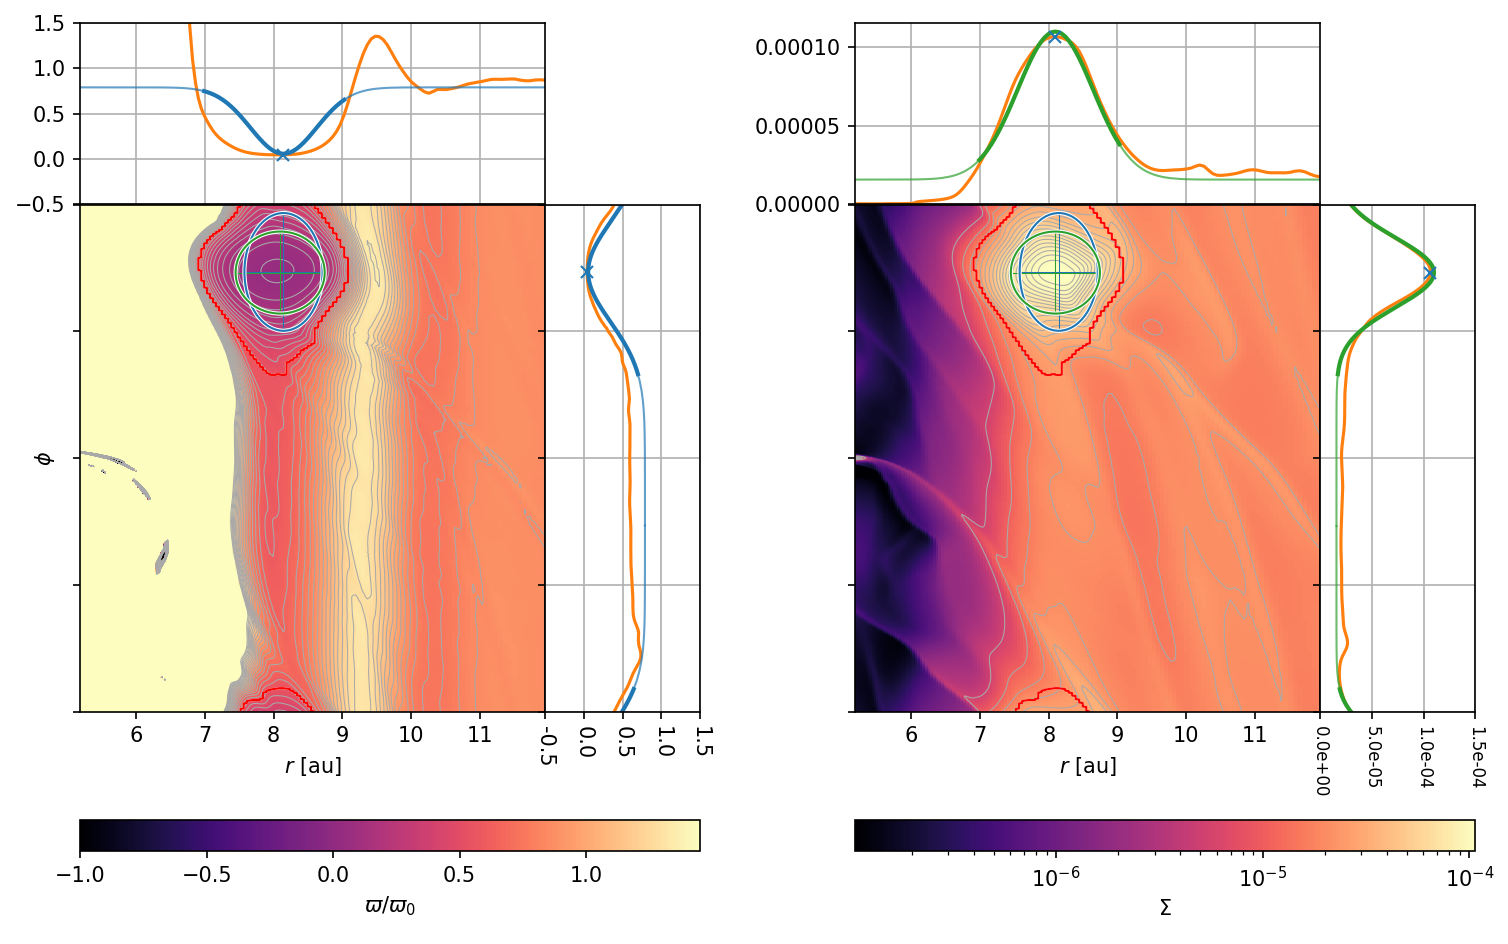

In [9]:
Rlims = [5.2, 12]
nl = np.argmin(np.abs(Xc[:,0]-Rlims[0]))
nr = np.argmin(np.abs(Xc[:,0]-Rlims[1]))
vd = Vortector(Xc[nl:nr,:], Yc[nl:nr,:], A[nl:nr,:], vortensity[nl:nr,:], Rho[nl:nr,:],
                         verbose=False, med=0.15, mear=np.inf,
                         levels=levels
                        )
# vd = vortector.Vortector(Xc, Yc, A, vortensity, Rho, Rho_background,
#                          [40,80], verbose=False, med=0.15, mear=np.inf,
#                          levels=levels
#                         )
%time vortices = vd.detect(include_mask=True, keep_internals=False)
for v in vd.vortices:
    try:
        v["strength"] = np.exp(-v["vortensity_median"])*v["mass"]
        print("strength = {:.2e}, mass = {:.2e} , min vort = {:.3f}, sigma fit r_diff = {:.2e} phi_diff = {:.2e}".format(
            v['strength'],v['mass'],v['vortensity_min'],v["sigma_fit_r_reldiff"],v["sigma_fit_phi_reldiff"]))
        print(f"    contour diff 2D = {v['sigma_fit_contour_diff_2D']:.2e} , contour reldiff 2D = {v['sigma_fit_contour_reldiff_2D']:.2e}")
        print(f"    ellipse diff 2D = {v['sigma_fit_ellipse_diff_2D']:.2e} , ellipse reldiff 2D = {v['sigma_fit_ellipse_reldiff_2D']:.2e}")
        print(f"    area_ratio_ellipse_to_contour = {v['sigma_fit_area_ratio_ellipse_to_contour']:.2e}")
    except KeyError:
        pass

# vd.show_fit_overview_1D(0)
show_fit_overview_2D(vd)
s = vd.vortices[0]["contour"]["stats"]
s["vortensity_min"]/s["azimuthal_at_vortensity_min"]["vortensity_med"]

In [10]:
vd.vortices[0]

{'contour': {'detection': {'contour_value': 0.5500000000000014,
   'opencv_contour_number': 31001,
   'uuid': 'f80eb7b8-5f60-4bfc-a193-a3dc3d658f02',
   'pixel_area': 10351.0,
   'pixel_arcLength': 821.9655101299286,
   'bounding_x_img': array([48, 91], dtype=int32),
   'bounding_y_img': array([168, 558], dtype=int32),
   'pnt_xlow_img': array([ 48, 379], dtype=int32),
   'pnt_xhigh_img': array([ 91, 354], dtype=int32),
   'pnt_ylow_img': array([ 71, 168], dtype=int32),
   'pnt_yhigh_img': array([ 74, 558], dtype=int32),
   'dx_img': 43,
   'dy_img': 390,
   'pnt_xlow': (48, 891),
   'pnt_xhigh': (91, 866),
   'pnt_ylow': (71, 680),
   'pnt_yhigh': (74, 46),
   'bbox_inds': array([[ 48, 891],
          [ 91, 866],
          [ 71, 680],
          [ 74,  46]]),
   'ellipse': {'center_img': (372.34942626953125, 70.32166290283203),
    'axesLengths_img': (39.789947509765625, 346.5018615722656),
    'angle_img': 89.96171569824219},
   'ellipse_area_delta_relative': 0.14768162348354313,
   '

In [11]:
vrad = simulation.fluids["gas"].get("2d", "velocity radial", Noutput).data.to_value("au/yr")
vrad = 0.5*(vrad[1:,:] + vrad[:-1,:])
vphi = simulation.fluids["gas"].get("2d", "velocity azimuthal", Noutput)
omega_frame = simulation.planets[0].get("omega frame").get_closest_to_time(vphi.get_time()).to("yr-1")
v_Frame = omega_frame*Xc*u.au
vphi = vphi.data.to_value("au/yr") + v_Frame.to_value("au/yr")
# vphi = vphi.data.to_value("au/yr")
vphi = np.pad(vphi, [[0,0],[0,1]], mode="wrap")
vphi = 0.5*(vphi[:,1:] + vphi[:,:-1])

vrad = vrad[nl:nr,:]
vphi = vphi[nl:nr,:]

2*np.pi*u.au/u.yr/np.sqrt(5.2)

<Quantity 2.75535903 AU / yr>

In [12]:
(astropy.constants.G*u.solMass).to_value("au3/yr2")

39.476926408897626

In [13]:
astropy.constants.G.to("au3 yr-2 solMass-1")

<Quantity 39.47692641 AU3 / (solMass yr2)>

In [14]:
def orbital_elements(r, phi, area, rho, vrad, vphi, mu, mask=None):

    #mass of each cell
    mass = rho * area

    #velocities in cartesian for each cell
    vx = vrad*np.cos(phi) - vphi*np.sin(phi)
    vy = vrad*np.sin(phi) + vphi*np.cos(phi)
    
    #cartesian coordinates
    x  = r * np.cos(phi)
    y  = r * np.sin(phi)

    #specific angular momentum and speed squared
    h2  = (x*vy - y*vx)**2
    v2  = vx*vx + vy*vy

    #smj axis from energy
    eng = 0.5*v2 - mu/r
    a   = -0.5*mu/eng
    
    #eccentricity
    ecc = np.sqrt(1.0-h2/(mu*a))
    
    #weight by mass, calculate weighted eccentricity of each cell
    if mask is None:
        mask = np.ones(mass.shape, dtype=bool)
        
    mass = mass[mask]
    a = a[mask]
    ecc = ecc[mask]
    
    total_mass = np.sum(mass)
    
    weighted_a = np.sum(a*mass)/total_mass
    weighted_ecc = np.sum(ecc*mass)/total_mass

    return {"a" : weighted_a, "e" : weighted_ecc}
mu = (astropy.constants.G*u.solMass).to_value("au3/yr2")

In [15]:
orbital_elements(vd.radius, vd.azimuth, vd.area, vd.surface_density, vrad, vphi, mu)

{'a': 9.528580184887595, 'e': 0.013720555775139273}

In [16]:
orbital_elements(vd.radius, vd.azimuth, vd.area, vd.surface_density, vrad, vphi, mu, mask=vd.vortices[0]["contour"]["mask"])

{'a': 8.195493475773421, 'e': 0.01896115529037313}

In [17]:
r0 = vd.vortices[0]["fits"]["surface_density"]["r0"]
hr = np.sqrt(2*np.log(2))*vd.vortices[0]["fits"]["surface_density"]["sigma_r"]
phi0 = vd.vortices[0]["fits"]["surface_density"]["phi0"]
hphi = np.sqrt(2*np.log(2))*vd.vortices[0]["fits"]["surface_density"]["sigma_phi"]
ellipse_mask = ((vd.radius - r0)/hr)**2 + ((vd.azimuth - phi0)/hphi)**2 <= 1
orbital_elements(vd.radius, vd.azimuth, vd.area, vd.surface_density, vrad, vphi, mu, mask=ellipse_mask)

{'a': 8.205883627696235, 'e': 0.016732488717037985}

In [18]:
from src.vortector import analyze
analyze.calc_orbital_elements(vd.radius, vd.azimuth, vd.area, vd.surface_density, vrad, vphi, mu, mask=ellipse_mask)

{'a': 8.205883627696235, 'e': 0.016732488717037985}

In [19]:
analyze.calc_orbital_elements_vortector(vd, 0, vrad, vphi, mu, region="contour")

{'a': 8.195493475773421, 'e': 0.01896115529037313}

In [20]:
analyze.calc_orbital_elements_vortector(vd, 0, vrad, vphi, mu, region="vortensity")

{'a': 8.229023604081727, 'e': 0.014429674232235064}

In [21]:
analyze.calc_orbital_elements_vortector(vd, 0, vrad, vphi, mu, region="surface_density")

{'a': 8.205883627696235, 'e': 0.016732488717037985}